# Module 3 Final Project
Student Name: Rachel Spiro
<br>Student Pace: Self Paced
<br>Instructor Name: Eli Thomas


## Project Goal:
Query the Northwind database to get the data needed to perform statistical analyses using hypothesis testing. The main questions I will be answering are:
1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
2. Do USA employees generate significantly higher revenue than UK employees?
3. Is there a statistically significant difference in the revenue from each region?
4. Are there statistically larger quantities of products ordered of non-refrigerated food compared to refrigerated food?

For reference, here is the database schema:

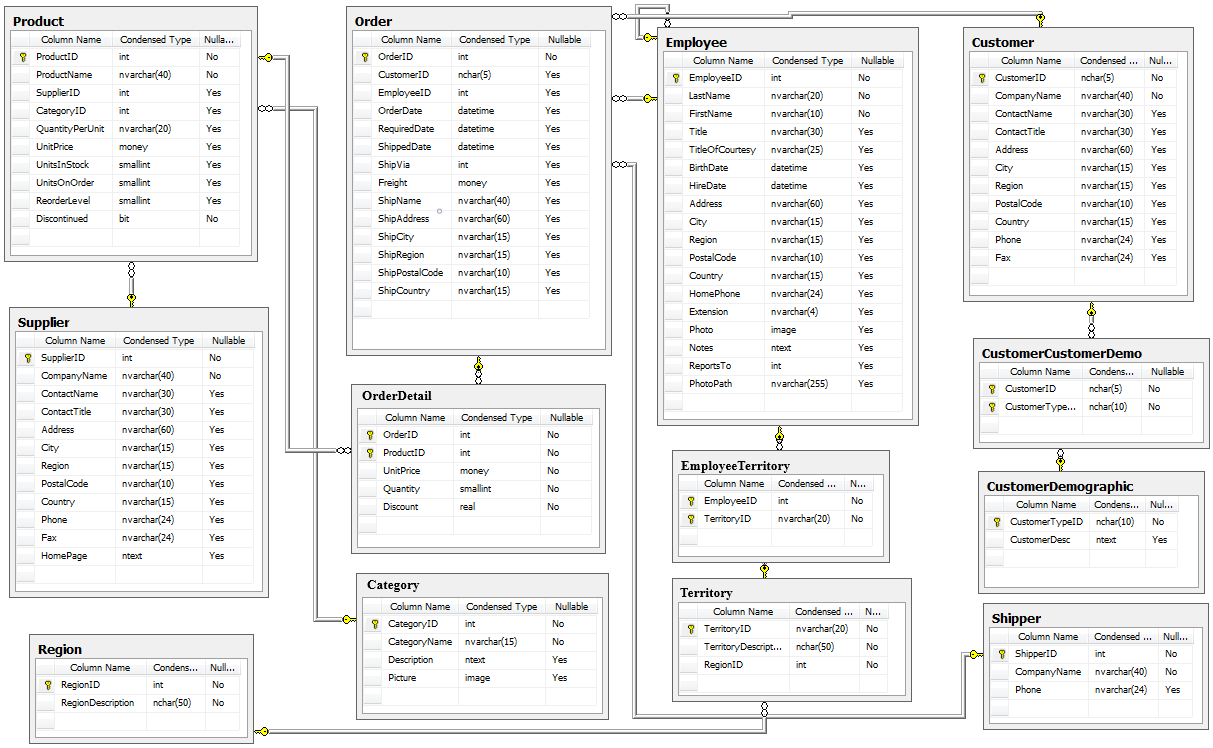

## Import Libraries:

In [1]:
# import necessary libraries
import sqlite3 # for reading the database
import pandas as pd # for working with dataframes
import numpy as np # for analysis
from scipy import stats # for significance levels and normality
import statsmodels.api as sm # for statistical exploration/testing
from statsmodels.formula.api import ols # for hypothesis testing
from statsmodels.stats.multicomp import pairwise_tukeyhsd # for pairwise comparisons
from statsmodels.stats.multicomp import MultiComparison # for multiple comparisons testing

# import below libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # hide any matplotlib warnings

## Connect to the database:
We will begin by retrieving all of the data from the database.

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

# list out all of the table names
tables = cur.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()
tables

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

It looks like we have 13 different tables within our database. Let's make each of those a pandas dataframe so that we can work more easily with the data.
## Convert all tables into dataframes: 

In [3]:
Employee_df = pd.read_sql_query('SELECT * FROM Employee;', conn)
Category_df = pd.read_sql_query('SELECT * FROM Category;', conn)
Customer_df = pd.read_sql_query('SELECT * FROM Customer;', conn)
Shipper_df = pd.read_sql_query('SELECT * FROM Shipper;', conn)
Supplier_df = pd.read_sql_query('SELECT * FROM Supplier;', conn)
Order_df = pd.read_sql_query('SELECT * FROM [Order];', conn)
Product_df = pd.read_sql_query('SELECT * FROM Product;', conn)
OrderDetail_df = pd.read_sql_query('SELECT * FROM OrderDetail;', conn)
CustomerCustomerDemo_df = pd.read_sql_query('SELECT * FROM CustomerCustomerDemo;', conn)
CustomerDemographic_df = pd.read_sql_query('SELECT * FROM CustomerDemographic;', conn)
Region_df = pd.read_sql_query('SELECT * FROM Region;', conn)
Territory_df = pd.read_sql_query('SELECT * FROM Territory;', conn)
EmployeeTerritory_df = pd.read_sql_query('SELECT * FROM EmployeeTerritory;', conn)

In [4]:
#Check to make sure tables were correctly made into dataframes:
Employee_df.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


Now that we have our data tables in dataframes and ready to be used, let's begin to answer each of our questions. 

## Question #1: 
### Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

For this first question, we will be using the OrderDetails table, specifically we are interested in the 'Discount' and 'Quantity' columns. First, we can explore the data in the Discount column. We will then need to group the data by orders that had a discount and orders that did not have a discount.
### 1.1 Exploratory Analysis

In [5]:
# See what the different discount values are
OrderDetail_df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [6]:
# Take a look at overall discount column summary statistics
OrderDetail_df.Discount.describe()

count    2155.000000
mean        0.056167
std         0.083450
min         0.000000
25%         0.000000
50%         0.000000
75%         0.100000
max         0.250000
Name: Discount, dtype: float64

It looks like most discounts are either at a .05, .10, .15, .20, or .25 percent discount, but we have a few random discount values as well.  It also looks like over half of the orders have no discount.

In [7]:
# Group data by having a discount vs. not having a discount. Within these groups, select data from the quantity column
# since we are intersted in how the quantities ordered differ between the two groups.
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
discount = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity']

Now that we have our data separated into the two groups that we want to analyze, let's inspect the data a bit to see if there appear to be any differences between the two groups

In [8]:
discount.describe()

count    838.000000
mean      27.109785
std       20.771439
min        1.000000
25%       12.000000
50%       20.000000
75%       36.000000
max      130.000000
Name: Quantity, dtype: float64

In [9]:
no_discount.describe()

count    1317.000000
mean       21.715262
std        17.507493
min         1.000000
25%        10.000000
50%        18.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

It does look like we have a higher mean for the discounted orders, but we cannot yet say if this is statistically significant. To get a visual look at the data, I am going to graph the Probability Density Function of each.

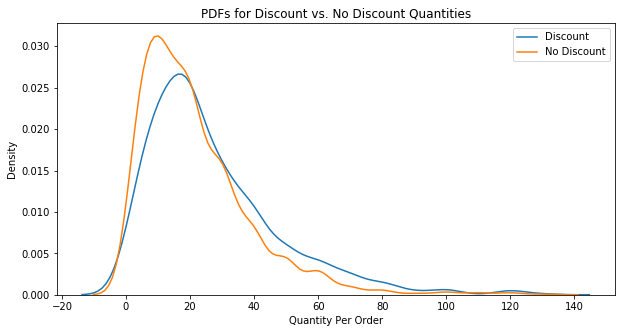

In [10]:
fig = plt.subplots(1, figsize=(10,5))
sns.kdeplot(discount,label='Discount')
sns.kdeplot(no_discount, label='No Discount')
plt.xlabel('Quantity Per Order')
plt.ylabel('Density')
plt.title('PDFs for Discount vs. No Discount Quantities')
plt.show()

From this visual, it again appears like there is a difference in the data of discounted vs. non-discounted orders. To determine if my initial guess of there being a statistical difference between the discounted and non-discounted data is correct, I will perform hypothesis testing. 

### 1.2 Hypothesis Testing

The following process will be used to perform my hypothesis test:
* Set up null and alternative hypotheses
* Explore the data and capture the necessary data points
* Perform the hypothesis test
* Interpret the findings and either accept or reject the null hypothesis


First, I must set my hypothesis. The Null Hypothesis ($H_{0}$) is typically that there is no difference between the samples, while the Alternative Hypothesis ($H_{A}$) is our educated guess about the relationship between our two samples. Below are the hypothesis I will be using to answer this question:

$H_{0}$ = Having a discount has has no effect on the quantity ordered
<br>$H_{A}$ = Having a discount either significantly increases or decreases the quantity ordered

We will be using an alpha value of .05 to determine if our data is statistically significant. This means that we are fine with accepting my alternative hypothesis as true if there is less than a 5% chance the results we are getting are actually due to randomness. 

To begin our hypothesis testing, we will need to choose the appropriate testing method.  We typically use a t-test for hypothesis testing, which tells us if there is a statistical difference between the means of two populations. If our sample sizes and/or sample variances are equal, then we would use a standard student's t-test. However, if sample size and variances are unequal between our 2 populations, then we should use an adaption of the student's t-test known as a Welch's t-test.

In [11]:
# test whether variances and sample size are equal
print('Are variances equal?:',np.var(discount) == np.var(no_discount))
print('Are sample sizes equal?:',len(discount) == len(no_discount))

Are variances equal?: False
Are sample sizes equal?: False


Both our sample size and variances are unequal between our sample of discounted orders and our sample of non-discounted orders, so the Welch's t-test should be utilized. Since we are determing if the discount either increases OR decreases the quantity ordered, we should proceed with a 2-tailed t-test. I will use the ttest_ind function to determine if there is any difference in the purchase quantity, and will pass the 'equal_var = False' function to indicate that our variances are unequal.

In [12]:
result = stats.ttest_ind(discount, no_discount, equal_var = False) # 2-tailed Welch's t-test
print('Reject Null Hypothesis' if result[1]<.05 else print('Failed to Reject Null Hypothesis'))
print(result)

Reject Null Hypothesis
Ttest_indResult(statistic=6.239069142123973, pvalue=5.65641429030433e-10)


The p-value tells us the chance of obtaining our results given the null hypothesis is true. We get a very low p-value here, which indicates that it is highly unlikely that our null hypothesis is true given the data we have. Therefore, we can reject the null hypothesis that having a discount has no effect on the quantity ordered. To quantify the size of the difference between the means of discounted and non-discounted orders, we can look at the effect size.

### 1.3 Effect Size
Effect size will help us understand the practical significance of our results. In other words, how meaningful is the statistical difference between our two groups. To understand the effect size, I will use Cohen's d, which represents the magnitude of differences between 2 groups on a given variable. Larger values for Cohen's d will indicate greater differentiation between the two groups.

The formula for Cohen's d is:
<br>𝑑  = effect size (difference of means) / pooled standard deviation

In [13]:
# Cohen's d formula:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [14]:
# Run Cohen's d for our data:
Cohen_d(discount, no_discount)

0.2862724481729282

With a Cohen d value of .286, we can say the discount has only a small effect on the quantity purchased.

### 1.4 Significance of each discount size
Now that we have compared the overall effect of having a discount vs. not having a discount, let's get more specific and break out the different discount levels.

In [15]:
# Look at how many different discounts there are
OrderDetail_df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Since .03, .02, .01, .04, and .06 have such few values, I will not be working with those data points. Instead, I will just work with the values for having no discount or having a discount of .05, .10, .15, .20, and .25. I will perform the same analysis as I did above for each of these discounted values vs. having no discount.

In [16]:
# Run a for loop to perform the hypothesis test and effect size calculations for each of the different discount
# amounts vs. having no discount

discounts_breakdown = pd.DataFrame(columns=["Discount %","Hypothesis Result","Mean","p-value","Cohen's d"],
                                   index=None)

discount_values = [.05,.10,.15,.20,.25]
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
for discounts in discount_values:
    discount = OrderDetail_df[OrderDetail_df['Discount']==discounts]['Quantity']
    result = stats.ttest_ind(discount, no_discount)
    cohens_d = Cohen_d(discount, no_discount)
    mean = OrderDetail_df[OrderDetail_df['Discount']==discounts]['Quantity'].mean()
    discounts_breakdown = discounts_breakdown.append({ "Discount %" : str(discounts*100)+'%' , 
          "Hypothesis Result" : 'Reject Null Hypothesis' if result[1]<0.05 else 'Failed To Reject Null Hypothesis',
            "Mean" : mean, "p-value" : result[1], "Cohen's d" : cohens_d } , ignore_index=True)    

discounts_breakdown

,Discount %,Hypothesis Result,Mean,p-value,Cohen's d
0,5.0%,Reject Null Hypothesis,28.010811,0.000011,0.346877
1,10.0%,Reject Null Hypothesis,25.236994,0.015501,0.195942
2,15.0%,Reject Null Hypothesis,28.382166,0.000011,0.372404
3,20.0%,Reject Null Hypothesis,27.024845,0.000326,0.300712
4,25.0%,Reject Null Hypothesis,28.240260,0.000018,0.366593


In [17]:
print('No Discount Mean:',OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity'].mean())

No Discount Mean: 21.715261958997722


From these low p-values, we can say that no matter what discount level there is, we reject the hypothesis that the discount has no effect on the quantity ordered.  Therefore, having a discount does have a statistically significant effect on the quantity of a product ordered. We can see from the mean values that having a discount increases the quantity orderd. All 5 discount options only have a small-medium effect on the quantity ordered, with a 15% discount having the largest effect.

## Question #2:

### Do USA employees generate significantly higher revenue than UK employees?
We will begin by selecting only the data columns we need to answer this question and by getting a general sense of the data we are working with.
### 2.1 Exploratory Analysis

In [18]:
# See what countries our employees are from and how many employees we have
print('Employee Country:',Employee_df.Country.unique())
print('Total # of Employees:', len(Employee_df.Id.unique()),'|',
      '# USA Employees:',len(Employee_df[Employee_df['Country'] == 'USA']),'|',
      '# UK Employees:',len(Employee_df[Employee_df['Country'] == 'UK']))

Employee Country: ['USA' 'UK']
Total # of Employees: 9 | # USA Employees: 5 | # UK Employees: 4


It looks like we have a total of 9 employees from 2 countries, with 5 from USA and 4 from UK.

In [19]:
# Select the data we want to work with
cur.execute('''SELECT EmployeeId, Country, sum(Quantity*UnitPrice*(1-Discount)) AS Total_Revenue, 
                    count(OrderId) as Total_Orders
                    FROM [Order] as o
                    JOIN Employee as e
                    ON o.EmployeeId = e.Id
                    JOIN OrderDetail as od
                    ON o.Id = od.OrderId
                    GROUP BY o.EmployeeId
                ;''')
employee_revenue = pd.DataFrame(cur.fetchall()) # put data into easy-to-use dataframe
employee_revenue.columns = [x[0] for x in cur.description] # add column labels to dataframe
employee_revenue # print dataframe

,EmployeeId,Country,Total_Revenue,Total_Orders
0,1,USA,192107.6045,345
1,2,USA,166537.7550,241
2,3,USA,202812.8430,321
3,4,USA,232890.8460,420
4,5,UK,68792.2825,117
5,6,UK,73913.1295,168
6,7,UK,124568.2350,176
7,8,USA,126862.2775,260
8,9,UK,77308.0665,107


In [20]:
# split the data into two datasets, each representing a country's revenue
USA = employee_revenue[employee_revenue.Country == 'USA']['Total_Revenue']
UK  = employee_revenue[employee_revenue.Country == 'UK']['Total_Revenue']

In [21]:
# look at overall statistical data for USA
USA.describe()

count         5.000000
mean     184242.265200
std       39935.344639
min      126862.277500
25%      166537.755000
50%      192107.604500
75%      202812.843000
max      232890.846000
Name: Total_Revenue, dtype: float64

In [22]:
# look at overall statistical data for UK
UK.describe()

count         4.000000
mean      86145.428375
std       25853.251513
min       68792.282500
25%       72632.917750
50%       75610.598000
75%       89123.108625
max      124568.235000
Name: Total_Revenue, dtype: float64

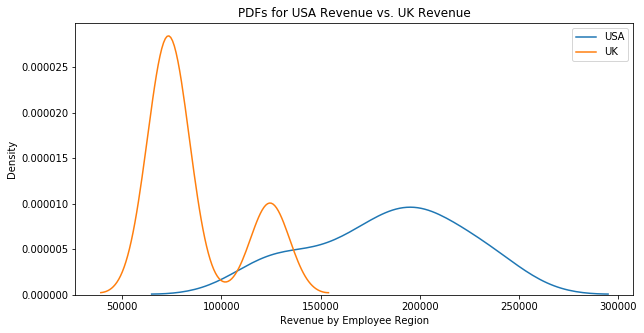

In [23]:
# Visually plot the PDFs for both samples
fig = plt.subplots(1, figsize=(10,5))
sns.kdeplot(USA,label='USA')
sns.kdeplot(UK, label='UK')
plt.xlabel('Revenue by Employee Region')
plt.ylabel('Density')
plt.title('PDFs for USA Revenue vs. UK Revenue')
plt.show()

It looks like our means are pretty far apart, and the visual shows rather different distributions for our two samples. Another thing to point out is that the USA employees have a greater total number of orders compared to UK employees, which suggests that there is a good chance USA employees as a whole generate greater revenue than UK employees. Let's continue with hypothesis testing to determine if the means of the two sample are truly statistical significant and if so, see how meaningful that difference is. 
### 2.2 Hypothesis Testing
Our Hypothesis:

$H_{0}$ = There is no difference in the revenue generated by employees in the USA vs. in the UK
<br>$H_{A}$ = The revenue generated by USA employees is statisically greater than the revenue generated by UK employees

We will proceed with a t-test using an alpha value of .05 to determine if our data is statistically significant. First we need to determine which t-test to use.

In [24]:
# test whether variances and sample size are equal
print('Are variances equal?:',np.var(USA) == np.var(UK))
print('Are sample sizes equal?:',len(USA) == len(UK))

Are variances equal?: False
Are sample sizes equal?: False


Since both our variances and our sample sizes differ between the two groups, a Welch's t-test will be used. We only want to know if the USA revenue is greater than the UK revenue (we are not concerned with if it is less than), so we will use a 1 sided t-test.

In [25]:
# Perform 1 sided t-test indicating unequal variances with the equal_var=False parameter. Divide p-value by 2 to 
# make this a 1 sided test.
result2 = stats.ttest_ind(USA,UK, equal_var = False)
print('Reject Null Hypothesis' if result2[1]/2<.05 else print('Failed to Reject Null Hypothesis'))
print('t-statistic:',result2[0],'p-value:',result2[1]/2)

Reject Null Hypothesis
t-statistic: 4.4494699048326485 p-value: 0.0015960863188947483


We end up with a very low p-value of ~.0016, confirming our initial instinct that the revenue generated by USA employees is significantly higher then the revenue generated by UK employees. Let's now take a look at how meaningful of a different there is using Cohen's d to analyze effect size.

### 2.3 Effect Size

In [26]:
# Run Cohen's d for our data:
Cohen_d(USA,UK)

2.851989501755086

2.85 indiacts a very large effect size. Therefore, we can say that when looking at the total revenue for each employee, employees in the USA generate a very significantly higher amount of revenue than do employees in the UK.

## Question #3:
### Is there a statistically significant difference in the revenue from each region?

### 3.1 Exploratory Analysis
First I will collect the necessary data points and take an initial look at the data.

In [27]:
# See what regions we have orders from
Order_df.ShipRegion.unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

We have 9 different regions that orders are coming in from.

In [28]:
# select desired data
cur.execute('''SELECT ShipRegion, OrderId, sum(Quantity*UnitPrice*(1-Discount)) AS Total_Invoice
                FROM [Order] o
                JOIN OrderDetail od
                ON o.Id = od.OrderId
                GROUP BY OrderId
                ;''')
region = pd.DataFrame(cur.fetchall())
region.columns = [x[0] for x in cur.description]
region.head()

,ShipRegion,OrderId,Total_Invoice
0,Western Europe,10248,440.00
1,Western Europe,10249,1863.40
2,South America,10250,1552.60
3,Western Europe,10251,654.06
4,Western Europe,10252,3597.90


In [29]:
# See how different the number of orders coming in from each region are
region.ShipRegion.value_counts()

Western Europe     276
North America      152
South America      145
British Isles       75
Southern Europe     64
Northern Europe     55
Central America     28
Scandinavia         28
Eastern Europe       7
Name: ShipRegion, dtype: int64

In [30]:
# Check the mean amount of revenue generated by each country
regions = ['British Isles','Central America','Eastern Europe','North America','Northern Europe','Scandinavia',
          'South America','Southern Europe','Western Europe']

means = []
for area in regions:
    mean = region[region['ShipRegion'] ==area]['Total_Invoice'].mean()
    means.append({area : mean})
    
means

[{'British Isles': 1452.6828666666668},
 {'Central America': 842.2170535714286},
 {'Eastern Europe': 504.5642857142857},
 {'North America': 1945.926976973684},
 {'Northern Europe': 1584.6575},
 {'Scandinavia': 876.614375},
 {'South America': 1185.2103827586209},
 {'Southern Europe': 706.6518359375001},
 {'Western Europe': 1830.3054655797102}]

It looks like the means of total revenue in each region do vary, however we also see varying amounts of orders from each region. Hypothesis testing will allow us to see if these means truly are significant from one another.

### 3.2 Hypothesis Testing
Our Hypothesis:

$H_{0}$  = There is no difference in the revenue generated by each region
<br>$H_{A}$  = There is at least one region with a significantly different revenue

We will use an ANOVA test here since we are looking at multiple different groups (i.e. each region is considered a different group). Similar to the t-tests used earlier, ANOVA will allow us to compare the means of total invoice amounts for each region to see if there are any statistical differences between different regions.

In [31]:
# Perform 2-sided ANOVA test. Use C() when working with categorical data
formula = 'Total_Invoice ~ C(ShipRegion)'
lm = ols(formula, region).fit()
result4 = sm.stats.anova_lm(lm, typ=2)
print(result4)

                     sum_sq     df         F        PR(>F)
C(ShipRegion)  1.449610e+08    8.0  5.556116  7.242547e-07
Residual       2.677522e+09  821.0       NaN           NaN


With a p-value on the right hand side of less than .05, we can reject the null hypothesis that there is no difference in the revenue generated in each region. This only tells us that at least one of the regions signficantly differs from one (or multiple) other regions. While this is helpful to know, it would be even more helpful to know which regions are generating statistically higher revenues, and which (if any) are similar to each other. To do this, we can perform a multiple comparisons analysis, which will compare all possible pairwise groups of means, and use Tukey's HSD test to determine the statistical significance of these comparisons.

In [32]:
mc = MultiComparison(region['Total_Invoice'], region['ShipRegion'])
mc_results = mc.tukeyhsd()
print(mc_results)

          Multiple Comparison of Means - Tukey HSD,FWER=0.05          
     group1          group2      meandiff    lower      upper   reject
----------------------------------------------------------------------
 British Isles  Central America -610.4658  -1854.3302  633.3986 False 
 British Isles   Eastern Europe -948.1186  -3167.8036 1271.5664 False 
 British Isles   North America   493.2441  -299.3021  1285.7903 False 
 British Isles  Northern Europe  131.9746  -865.0911  1129.0403 False 
 British Isles    Scandinavia   -576.0685  -1819.9329  667.7959 False 
 British Isles   South America  -267.4725  -1066.3143  531.3693 False 
 British Isles  Southern Europe  -746.031  -1701.7955  209.7334 False 
 British Isles   Western Europe  377.6226  -353.7395  1108.9847 False 
Central America  Eastern Europe -337.6528  -2711.048  2035.7425 False 
Central America  North America  1103.7099   -51.3367  2258.7566 False 
Central America Northern Europe  742.4404   -561.455  2046.3359 False 
Centra

From these Tukey results we see that most regions do not generate statistically different amount of revenues. However, South America and Southern Europe do show statistical differences to both North America and Western Europe. I will do a quick check to see which of the means is larger, and then will calculate the effect size of each.

In [33]:
print('South America vs. North America:', region[region['ShipRegion'] =='South America']['Total_Invoice'].mean() 
      - region[region['ShipRegion'] =='North America']['Total_Invoice'].mean())
print('Southern Europe vs. North America:', region[region['ShipRegion'] =='Southern Europe']['Total_Invoice'].mean() 
      - region[region['ShipRegion'] =='North America']['Total_Invoice'].mean())
print('South America vs. Western Europe:', region[region['ShipRegion'] =='South America']['Total_Invoice'].mean() 
      - region[region['ShipRegion'] =='Western Europe']['Total_Invoice'].mean())
print('Southern Europe vs. Western Europe:', region[region['ShipRegion'] =='Southern Europe']['Total_Invoice'].mean() 
      - region[region['ShipRegion'] =='Western Europe']['Total_Invoice'].mean())

South America vs. North America: -760.7165942150632
Southern Europe vs. North America: -1239.2751410361839
South America vs. Western Europe: -645.0950828210894
Southern Europe vs. Western Europe: -1123.65362964221


### 3.3 Effect Size

In [34]:
# Run Cohen's d for our data:
group1 = ['South America','Southern Europe']
group2 = ['North America','Western Europe']

d = pd.DataFrame(columns = ["Region1","Region2","Cohen's d"], index = None)
for area1, area2 in [(area1,area2) for area1 in group1 for area2 in group2]: 
    cohen = Cohen_d(region[region['ShipRegion'] ==area1]['Total_Invoice']
                          ,region[region['ShipRegion'] ==area2]['Total_Invoice'])
    d = d.append({"Region1":area1,"Region2":area2, "Cohen's d":cohen}, ignore_index=True)
    
d

,Region1,Region2,Cohen's d
0,South America,North America,-0.393361
1,South America,Western Europe,-0.338868
2,Southern Europe,North America,-0.653733
3,Southern Europe,Western Europe,-0.600324


From these results, we can say that there are significantly higher revenues from North America compared to either South America or Southern Europe. Similarly, there are significantly higher revenues from Western Europe compared to either South America or Southern Europe. Additionally, the effect size between South America and either other region is on the smaller side, while we see a medium sized difference between Southern Europe and the other regions.

## Question #4:


### Are there statistically larger quantites of products ordered of non-refrigerated food compared to refrigerated food?
### 4.1 Exploratory Analysis
First I will collect the necessary data points and take an initial look at the data.

In [35]:
# See what the categories of food items are
print(Category_df.CategoryName.groupby(Category_df.Id).unique())

Id
1         [Beverages]
2        [Condiments]
3       [Confections]
4    [Dairy Products]
5    [Grains/Cereals]
6      [Meat/Poultry]
7           [Produce]
8           [Seafood]
Name: CategoryName, dtype: object


It looks like we have 8 different categories. I am going to count Beverages, Condiments, Confections, and Grains/Cereals as non-refrigerated items (IDs 1,2,3,5) and I will count Dairy Products, Meat/Poultry, Produce, and Seafood (IDs 4,6,7,8) as refrigerated items. Let's group these together using the Product table so that we will be able to easily connect this data to the quantity purchased in the Order Detail table.

In [36]:
# collect non-refrigerated data
cur.execute('''SELECT CategoryId, Quantity
                FROM Product p
                JOIN OrderDetail od
                USING(UnitPrice)
                WHERE CategoryId in ('1','2','3','5')
                ;''')
non_refrigerated = pd.DataFrame(cur.fetchall())
non_refrigerated.columns = [x[0] for x in cur.description]
non_refrigerated.head()

,CategoryId,Quantity
0,1,2
1,1,2
2,1,2
3,1,2
4,1,3


In [37]:
# collect refrigerated data
cur.execute('''SELECT CategoryId, Quantity
                FROM Product p
                JOIN OrderDetail od
                USING(UnitPrice)
                WHERE CategoryId in ('4','6','7','8')
                ;''')
refrigerated = pd.DataFrame(cur.fetchall())
refrigerated.columns = [x[0] for x in cur.description]
refrigerated.head()

,CategoryId,Quantity
0,7,1
1,7,3
2,7,4
3,7,5
4,7,6


Let's take an initial look at the refrigerated vs. non-refrigerated data to see if it seems to be different.

In [38]:
non_refrigerated['Quantity'].describe()

count    1536.000000
mean       23.683594
std        19.538590
min         1.000000
25%        10.000000
50%        20.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

In [39]:
refrigerated['Quantity'].describe()

count    922.000000
mean      24.034707
std       19.373042
min        1.000000
25%       10.000000
50%       20.000000
75%       30.000000
max      120.000000
Name: Quantity, dtype: float64

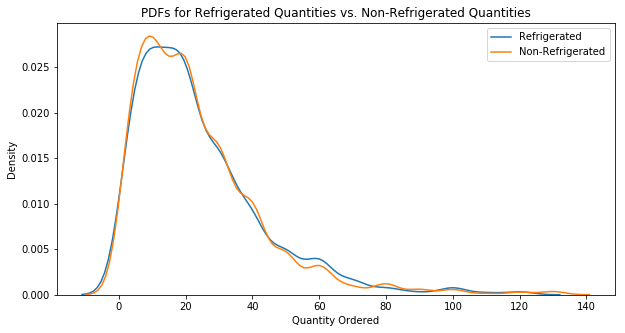

In [40]:
# Visually plot the PDFs for both samples
fig = plt.subplots(1, figsize=(10,5))
sns.kdeplot(refrigerated['Quantity'],label='Refrigerated')
sns.kdeplot(non_refrigerated['Quantity'], label='Non-Refrigerated')
plt.xlabel('Quantity Ordered')
plt.ylabel('Density')
plt.title('PDFs for Refrigerated Quantities vs. Non-Refrigerated Quantities')
plt.show()

Our means and standard deviations look very similar as do the full distributions from our visual above, but there may still be a difference between the two. Let's do hypothesis testing to determine if there truly is a statistically significant difference between the quantity of refrigerated foods and non-refrigerated foods ordered.

### 4.2 Hypothesis Testing
Our Hypothesis:

$H_{0}$ = There is no difference in the quantity of products ordered between refrigerated and non-refrigerated food
<br>$H_{A}$ = There are significantly higher quantities of products ordered for non-refrigerated food than refrigerated food

We will proceed with our t-test using an alpha value of .05 to determine if our data is statistically significant. We will use a 1-tailed t-test here since we only want to know if there is a higer quantity ordered of non-refrigerated food. First, we will determine if a Student's t-test or Welch's t-test should be used.

In [41]:
# Test whether variances and sample size are equal
print('Are variances equal?:',np.var(refrigerated['Quantity']) == np.var(non_refrigerated['Quantity']))
print('Are sample sizes equal?:',len(refrigerated['Quantity']) == len(non_refrigerated['Quantity']))

Are variances equal?: False
Are sample sizes equal?: False


We will proceed with using Welch's t-test due to unequal variances and sample sizes between our two samples.

In [42]:
# Perform Welch's 1-tailed t-test. Divide p-value by 2 to get 1-tailed result.
result3 = stats.ttest_ind(non_refrigerated['Quantity'],refrigerated['Quantity'], equal_var = False)
print('Reject Null Hypothesis' if result3[1]/2<.05 else print('Failed to Reject Null Hypothesis'))
print('t-statistic:',result3[0], 'p-value:',result3[1]/2)

Failed to Reject Null Hypothesis
None
t-statistic: -0.4336368615732117 p-value: 0.33230003606833947


Since our p-value is greater than .05, we fail to reject our null hyoothesis, indicating that whether or not the food is refrigerated has no impact on the quantity of a product ordered.

## Conclusions:

 - __Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?__
     - Yes, having a discount of either 5%, 10%, 15%, 20%, or 25% results in statistically higher quantities being ordered. However, the effect sizes are on the smaller side for all of these differences, meaning there is not a huge difference between the quantities ordered with and without a discount.
 - __Question 2: Do USA employees generate signficantly higher revenue than UK employees?__
     - Yes, USA employees generate significantly higher total revenues than their collegues in the UK. With a large effect size, this is a very meaningful difference.
 - __Question 3: Is there a statistically significant difference in the revenue from each region?__
     - Most regions do not have a significant difference in the amount of revenue generated. However, we do see that both North America and Western Europe produce significantly higher revenues than either South America or Southern Europe. There is a greater difference in the revenues between North America/Western Europe and Southern Europe compared to North America/Western Europe and South America.
 - __Question 4: Are there statistically larger quantities ordered of non-refrigerated products compared to refrigerated products?__
     - No, there is no difference in the quantity of refrigerated and non-refrigerated products ordered.
     
### Next Steps:
A few things to look into next:
- Are shipping costs significantly different for each shipping company?
- Do consumers purchase domestically produced products significantly more frequently than they purchase imported products?
- Is there a statistically significant difference in the quantity ordered of each different product type?
- On average, do USA employees generate significantly greater profits per order than UK employees?